In [3]:
import string

import numpy as np
import optuna 
import polars as pl

from matplotlib import pyplot as plt
from postpredict.dependence import Schaake
from postpredict.weighters import UnivariateGaussianKernel
from postpredict.metrics import energy_score


In [68]:
def sim_from_ar(n, n_timesteps, phi, tau, rng, y_0 = None):
    """
    Simulate observations from a Gaussian AR(1) process with AR coefficient phi
    and innovation standard deviation tau.
    """
    if y_0 is None:
        marginal_variance = tau**2 / (1 - phi**2)
        y_0 = rng.normal(loc=0.0, scale=np.sqrt(marginal_variance), size=(n, 1))
    
    if type(y_0) == float:
        y_0 = np.full((n, 1), y_0)
    
    innovations = rng.normal(loc=0.0, scale=tau, size=(n, n_timesteps))
    result = [y_0]
    for i in range(n_timesteps):
        result.append(phi * result[-1] + innovations[:, i:(i+1)])
    return np.concatenate(result[1:], axis = 1)


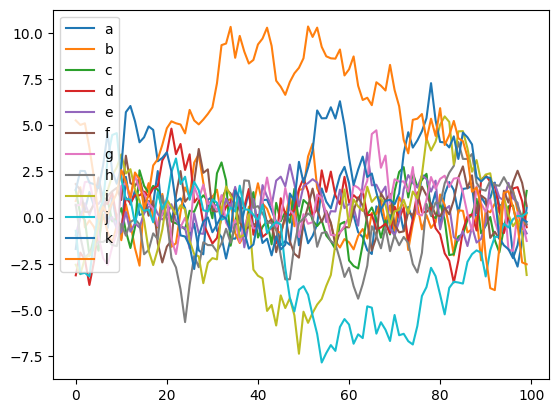

In [60]:
loc_phis = np.linspace(0.59, 0.99, num=12)
loc_seeds = [212 + i * 10 for i in range(len(loc_phis))]

n_obs_timesteps = 100
obs_data = pl.concat([
    pl.DataFrame({
        "location": string.ascii_letters[i],
        "population": 1000000 * phi,
        "t": np.arange(n_obs_timesteps),
        "y": sim_from_ar(n=1, n_timesteps=n_obs_timesteps, phi = phi, tau = 1.0, rng = np.random.default_rng(loc_seeds[i])).squeeze()
    }) \
        for i, phi in enumerate(loc_phis)
])
obs_data = obs_data.with_columns(pop_normalized = pl.col("population") / 1000000)

locations = sorted(obs_data["location"].unique())

for loc in locations:
    plt.plot(
        obs_data
        .filter(pl.col("location") == loc)
        ["y"],
        label = loc
    )

plt.legend()
plt.show()


In [67]:
type(9.) == float

True

In [71]:
l_ind = 10
n_samples = 15
df =  obs_data.filter(pl.col("t") <= 10)
data = pl.DataFrame(
)

In [73]:
data.columns = [f"hor{h}" for h in range(horizon)]
data

t0,t1,t2,t3
f64,f64,f64,f64
2.473953,3.253527,3.536941,3.505589
5.126272,3.993524,2.388657,3.071411
3.710584,3.634787,3.012416,1.903678
1.77974,2.111428,0.395867,0.090831
2.279021,2.257362,3.090864,2.356384
…,…,…,…
0.647204,-0.170586,-1.08151,0.661459
2.848898,2.564651,3.834418,3.81343
2.165813,3.327757,3.622868,2.79157


In [81]:
pl.concat([
                pl.DataFrame({
                    "location": loc,
                    "population": df.filter(pl.col("location") == loc)["population"][0],
                    "ref_t": df["t"].max(),
                    "output_type": "sample",
                    "output_type_id": range(l_ind * n_samples, (l_ind + 1) * n_samples)
                }),
                pl.DataFrame(
                    sim_from_ar(
                        n = n_samples,
                        n_timesteps=horizon,
                        phi=loc_phis[l_ind],
                        tau=1.0,
                        rng=np.random.default_rng(),
                        y_0 = df.filter(pl.col("location") == loc)["y"][-1]
                    )
                )
            ],
            how='horizontal') \
    .unpivot(
        on=[f"column_{h}" for h in range(horizon)],
        index=["location", "population", "ref_t", "output_type", "output_type_id"]
    ) \
    .with_columns(
        horizon=pl.col("variable").str.slice(7).cast(int)
    ) \
    .drop("variable")

location,population,ref_t,output_type,output_type_id,value,horizon
str,f64,i32,str,i64,f64,i64
"""l""",990000.0,10,"""sample""",150,1.531198,0
"""l""",990000.0,10,"""sample""",151,3.640662,0
"""l""",990000.0,10,"""sample""",152,2.133511,0
"""l""",990000.0,10,"""sample""",153,0.925267,0
"""l""",990000.0,10,"""sample""",154,3.663243,0
…,…,…,…,…,…,…
"""l""",990000.0,10,"""sample""",160,1.957907,3
"""l""",990000.0,10,"""sample""",161,-0.268011,3
"""l""",990000.0,10,"""sample""",162,1.753538,3


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_3946/4105992927.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


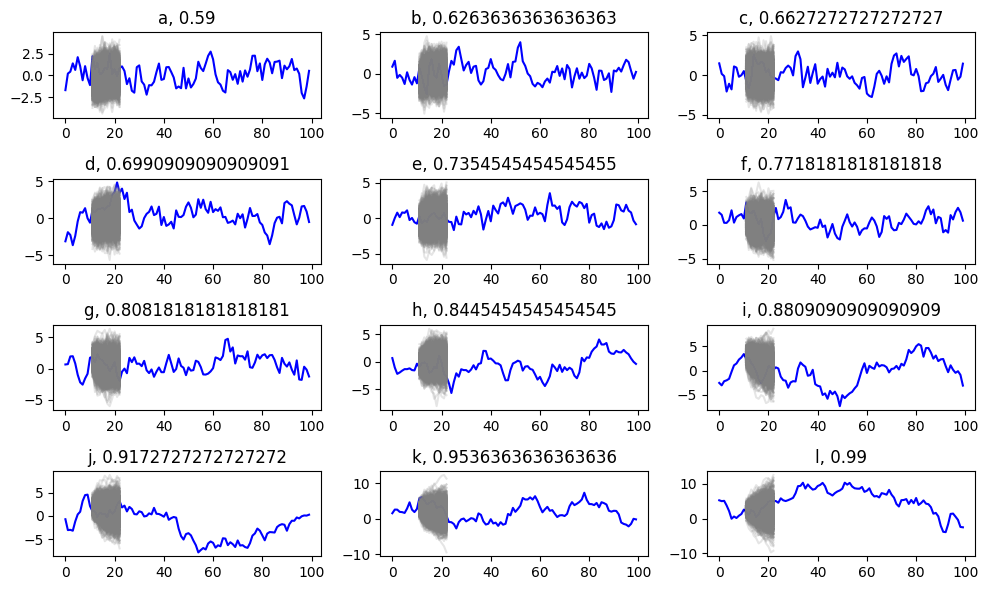

In [89]:
def generate_predictions(df, n_samples = 100, horizon = 4):
    predictions = pl.concat([
        pl.concat([
            pl.concat(
                [
                    pl.DataFrame({
                        "location": loc,
                        "population": df.filter(pl.col("location") == loc)["population"][0],
                        "ref_t": df["t"].max(),
                        "output_type": "sample",
                        "output_type_id": range(l_ind * n_samples, (l_ind + 1) * n_samples)
                    }),
                    pl.DataFrame(
                        sim_from_ar(
                            n = n_samples,
                            n_timesteps=horizon,
                            phi=loc_phis[l_ind],
                            tau=1.0,
                            rng=np.random.default_rng(),
                            y_0 = df.filter(pl.col("location") == loc)["y"][-1]
                        )
                    )
                ],
                how='horizontal'
            ) \
            .unpivot(
                on=[f"column_{h}" for h in range(horizon)],
                index=["location", "population", "ref_t", "output_type", "output_type_id"]
            ) \
            .with_columns(
                horizon=pl.col("variable").str.slice(7).cast(int) + 1
            ) \
            .drop("variable")
        ]) \
        for l_ind, loc in enumerate(locations)
    ])
    return predictions

n_samples = 1000
horizon = 12
predictions_time_10 = generate_predictions(obs_data.filter(pl.col("t") <= 10), n_samples=n_samples, horizon=horizon)

ncol = 3
nrow = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 6))

for i, l, in enumerate(locations):
    row_ind = i // 3
    col_ind = i % 3
    ax[row_ind, col_ind].plot(obs_data.filter(pl.col("location") == l)["y"], c="blue")
    ax[row_ind, col_ind].title.set_text(f"{l}, {loc_phis[i]}")
    loc_preds = (
        predictions_time_10
        .filter(pl.col("location") == l)
        .with_columns(
            target_t = pl.col("ref_t") + pl.col("horizon"),
            idx_within_loc = pl.col("output_type_id") - pl.col("output_type_id").min()
        )
    )
    for j in range(n_samples):
        ax[row_ind, col_ind].plot(
            loc_preds.filter(pl.col("idx_within_loc") == j)["target_t"],
            loc_preds.filter(pl.col("idx_within_loc") == j)["value"],
            c="gray",
            alpha=0.2
        )
        

fig.tight_layout()
fig.show()

In [90]:
horizon = 12
predictions_all_ref_times = pl.concat([
    generate_predictions(obs_data.filter(pl.col("t") <= t), n_samples=n_samples, horizon=horizon) \
        for t in range(n_obs_timesteps)
])
predictions_all_ref_times = predictions_all_ref_times.with_columns(pop_normalized = pl.col("population") / 1000000)

In [91]:
predictions_all_ref_times

location,population,ref_t,output_type,output_type_id,value,horizon,pop_normalized
str,f64,i32,str,i64,f64,i64,f64
"""a""",590000.0,0,"""sample""",0,-1.766497,1,0.59
"""a""",590000.0,0,"""sample""",1,-0.292741,1,0.59
"""a""",590000.0,0,"""sample""",2,-1.08503,1,0.59
"""a""",590000.0,0,"""sample""",3,-3.1535,1,0.59
"""a""",590000.0,0,"""sample""",4,-1.838941,1,0.59
…,…,…,…,…,…,…,…
"""l""",990000.0,99,"""sample""",11995,-1.72871,12,0.99
"""l""",990000.0,99,"""sample""",11996,0.786952,12,0.99
"""l""",990000.0,99,"""sample""",11997,-5.19547,12,0.99


In [88]:
wide_model_out

location,population,ref_t,output_type,output_type_id,pop_normalized,postpredict_horizon0,postpredict_horizon1,postpredict_horizon2,postpredict_horizon3,postpredict_horizon4,postpredict_horizon5,postpredict_horizon6,postpredict_horizon7,postpredict_horizon8,postpredict_horizon9,postpredict_horizon10,postpredict_horizon11
str,f64,i32,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""a""",590000.0,0,"""sample""",627000,0.59,0.586182,-1.031702,0.680502,0.283792,1.044041,1.522784,2.523949,2.699252,1.018184,0.730651,0.737746,1.203316
"""a""",590000.0,0,"""sample""",627001,0.59,0.485192,0.000921,0.349211,0.748679,1.171289,1.543839,0.990339,0.053275,0.609429,0.806275,-0.922909,-1.874235
"""a""",590000.0,0,"""sample""",627002,0.59,-2.950609,0.011926,-1.636081,0.697144,1.338088,2.328316,-0.029781,1.353923,0.715243,-1.069448,-0.355619,-0.838845
"""a""",590000.0,0,"""sample""",627003,0.59,0.230567,-1.146416,0.145648,0.265257,-0.922182,-0.565669,-0.595471,-0.750313,-1.61615,-0.446134,0.066404,-1.209319
"""a""",590000.0,0,"""sample""",627004,0.59,1.278328,-0.110933,-1.637822,-2.508947,0.1673,0.03358,-0.577991,-1.547271,-1.285212,-1.256208,-0.91518,-1.89079
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""l""",990000.0,99,"""sample""",319995,0.99,-1.388079,0.086263,0.338829,2.578272,2.659279,2.354044,2.567294,2.384081,2.85247,2.289699,2.70581,3.444449
"""l""",990000.0,99,"""sample""",319996,0.99,-2.814804,-0.560621,-1.990111,-2.83809,-2.638437,-1.163306,-1.196108,-2.138949,-1.920177,-2.49334,-1.513407,-0.797648
"""l""",990000.0,99,"""sample""",319997,0.99,-2.164216,-1.313565,-0.425408,-0.77371,-0.150597,-0.165613,-0.537847,-1.74582,-2.888969,-2.496715,-4.347165,-3.97773


In [92]:
# Is energy score sensitive to dependence structure, given fixed marginals?
ss = Schaake(weighter=UnivariateGaussianKernel(h = 1.0))
ss.fit(df=obs_data, key_cols=["location"], time_col="t", obs_col="y", feat_cols=["pop_normalized"])

ss._build_train_X_Y(min_horizon=1, max_horizon=horizon,
                    obs_mask = None)

wide_model_out = ss._pivot_horizon(
    model_out=predictions_all_ref_times,
    reference_time_col="ref_t",
    horizon_col="horizon",
    idx_col="output_type_id",
    pred_col="value"
)
energy_score(
    wide_model_out.with_columns(t = pl.col("ref_t").cast(ss.df["t"].dtype)),
    ss.df,
    key_cols = ss.key_cols + ["t"],
    pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
    obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
    reduce_mean = True
)

3.913721093879478

In [94]:
wide_model_out_shuffled = (
    wide_model_out
    .with_columns(
        postpredict_horizon1 = pl.col("postpredict_horizon1").shuffle(seed=42).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon2 = pl.col("postpredict_horizon2").shuffle(seed=420).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon3 = pl.col("postpredict_horizon3").shuffle(seed=4200).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon4 = pl.col("postpredict_horizon4").shuffle(seed=42000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon5 = pl.col("postpredict_horizon5").shuffle(seed=420000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon6 = pl.col("postpredict_horizon6").shuffle(seed=4200000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon7 = pl.col("postpredict_horizon7").shuffle(seed=42000000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon8 = pl.col("postpredict_horizon8").shuffle(seed=420000000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon9 = pl.col("postpredict_horizon9").shuffle(seed=4200000000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon10 = pl.col("postpredict_horizon10").shuffle(seed=42000000000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon11 = pl.col("postpredict_horizon11").shuffle(seed=420000000000).over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon12 = pl.col("postpredict_horizon12").shuffle(seed=4200000000000).over(["location", "population", "ref_t", "output_type", "pop_normalized"])
    )
)

energy_score(
    wide_model_out_shuffled.with_columns(t = pl.col("ref_t").cast(ss.df["t"].dtype)),
    ss.df,
    key_cols = ss.key_cols + ["t"],
    pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
    obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
    reduce_mean = True
)

4.01469653248981

In [95]:
wide_model_out_shuffled = (
    wide_model_out
    .with_columns(
        postpredict_horizon1 = pl.col("postpredict_horizon1").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon2 = pl.col("postpredict_horizon2").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon3 = pl.col("postpredict_horizon3").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon4 = pl.col("postpredict_horizon4").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon5 = pl.col("postpredict_horizon5").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon6 = pl.col("postpredict_horizon6").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon7 = pl.col("postpredict_horizon7").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon8 = pl.col("postpredict_horizon8").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon9 = pl.col("postpredict_horizon9").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon10 = pl.col("postpredict_horizon10").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon11 = pl.col("postpredict_horizon11").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"]),
        postpredict_horizon12 = pl.col("postpredict_horizon12").shuffle().over(["location", "population", "ref_t", "output_type", "pop_normalized"])
    )
)

energy_score(
    wide_model_out_shuffled.with_columns(t = pl.col("ref_t").cast(ss.df["t"].dtype)),
    ss.df,
    key_cols = ss.key_cols + ["t"],
    pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
    obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
    reduce_mean = True
)

4.015100937484611

In [96]:
n_folds = 5
n_times_per_fold = (n_obs_timesteps - horizon) // n_folds
folds = [
    {"t": list(range(i * n_times_per_fold, (i+1) * n_times_per_fold))} \
        for i in range(n_folds)
]
folds


[{'t': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]},
 {'t': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]},
 {'t': [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]},
 {'t': [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]},
 {'t': [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]}]

In [97]:
reference_time_col = "ref_t"

def get_metric_one_val_fold(ss, model_out, folds, val_fold_ind, metric_fn):
    """
    Obtain predictions for the validation set where the only observations
    used for templates are from outside the validation set.
    """
    val_model_out = model_out.filter(
        pl.col(reference_time_col).is_in(folds[val_fold_ind]["t"])
    )
    
    train_obs_mask = ~obs_data["t"].is_in(folds[val_fold_ind]["t"])
    
    transformed_val_model_out = ss.transform(
        model_out=val_model_out,
        reference_time_col=reference_time_col,
        horizon_col="horizon",
        pred_col="value",
        idx_col="output_type_id",
        obs_mask=train_obs_mask,
        return_long_format=False
    )
    
    metric = metric_fn(
        transformed_val_model_out.with_columns(t = pl.col("ref_t").cast(ss.df["t"].dtype)),
        ss.df,
        key_cols = ss.key_cols + ["t"],
        pred_cols = [f"postpredict_horizon{h}" for h in range(1, horizon + 1)],
        obs_cols = [f"y_shift_p{h}" for h in range(1, horizon + 1)],
        reduce_mean = True
    )
    
    return metric


def get_metric_crossval(ss, model_out, folds, metric_fn):
    metrics_by_fold = np.array([
        get_metric_one_val_fold(ss, model_out, folds, val_fold_ind, metric_fn) \
            for val_fold_ind in range(len(folds))
    ])
    print(metrics_by_fold)
    
    return np.mean(metrics_by_fold)


In [98]:
ss = Schaake(weighter=UnivariateGaussianKernel(h = 1.0))
ss.fit(df=obs_data, key_cols=["location"], time_col="t", obs_col="y", feat_cols=["pop_normalized"])

get_metric_crossval(ss=ss, model_out=predictions_all_ref_times, folds=folds, metric_fn=energy_score)


[4.05213967 3.61819575 4.44042262 3.71457681 3.92153278]


np.float64(3.9493735277260074)

In [99]:
def objective(trial):
    h = trial.suggest_float("h", low=1e-6, high=1e2, log=True)
    ss = Schaake(weighter=UnivariateGaussianKernel(h = h))
    ss.fit(df=obs_data, key_cols=["location"], time_col="t", obs_col="y", feat_cols=["pop_normalized"])
    return get_metric_crossval(ss=ss, model_out=predictions_all_ref_times, folds=folds, metric_fn=energy_score)

study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2024-10-18 21:08:20,760] A new study created in memory with name: no-name-3556e132-0906-42f1-9406-6c592c456904
[I 2024-10-18 21:09:40,732] Trial 0 finished with value: 3.9374186567295957 and parameters: {'h': 0.003201565869803209}. Best is trial 0 with value: 3.9374186567295957.


[4.0417138  3.60511293 4.43241771 3.70587976 3.90196908]


[I 2024-10-18 21:11:07,850] Trial 1 finished with value: 3.9489273489441894 and parameters: {'h': 1.6221866070049595}. Best is trial 0 with value: 3.9374186567295957.


[4.05219123 3.61740804 4.43932081 3.71401008 3.92170658]


[I 2024-10-18 21:12:30,966] Trial 2 finished with value: 3.949997035622785 and parameters: {'h': 97.27895960642897}. Best is trial 0 with value: 3.9374186567295957.


[4.05375699 3.61818138 4.44037355 3.71560911 3.92206415]


[I 2024-10-18 21:13:52,529] Trial 3 finished with value: 3.958831279150824 and parameters: {'h': 7.060698463479763e-06}. Best is trial 0 with value: 3.9374186567295957.


[4.03056669 3.63887543 4.44020243 3.73512956 3.94938228]


[I 2024-10-18 21:15:30,509] Trial 4 finished with value: 3.9587373839855147 and parameters: {'h': 2.4543104043581227e-05}. Best is trial 0 with value: 3.9374186567295957.


[4.03067775 3.63932895 4.44042932 3.73544889 3.94780202]


[I 2024-10-18 21:17:00,589] Trial 5 finished with value: 3.937378689830181 and parameters: {'h': 0.0034229254124623887}. Best is trial 5 with value: 3.937378689830181.


[4.04245001 3.60514838 4.43243184 3.70602745 3.90083578]


[I 2024-10-18 21:18:30,981] Trial 6 finished with value: 3.9498839692828724 and parameters: {'h': 29.444808036645917}. Best is trial 5 with value: 3.937378689830181.


[4.05211403 3.6186859  4.44117941 3.71539775 3.92204275]


[I 2024-10-18 21:19:53,033] Trial 7 finished with value: 3.9372049013595527 and parameters: {'h': 0.003509043685204039}. Best is trial 7 with value: 3.9372049013595527.


[4.04145663 3.60569865 4.43261144 3.70438886 3.90186893]


[I 2024-10-18 21:21:14,946] Trial 8 finished with value: 3.9587945098851725 and parameters: {'h': 2.4231868614949738e-05}. Best is trial 7 with value: 3.9372049013595527.


[4.03180459 3.63924143 4.43902771 3.73576609 3.94813272]


[I 2024-10-18 21:22:38,867] Trial 9 finished with value: 3.950109006030201 and parameters: {'h': 58.04551117362054}. Best is trial 7 with value: 3.9372049013595527.


[4.05409494 3.61831079 4.440242   3.71611183 3.92178546]


In [100]:
study.trials_dataframe()


,number,value,datetime_start,datetime_complete,duration,params_h,state
0,0,3.937419,2024-10-18 21:08:20.762055,2024-10-18 21:09:40.732679,0 days 00:01:19.970624,0.003202,COMPLETE
1,1,3.948927,2024-10-18 21:09:40.733773,2024-10-18 21:11:07.850218,0 days 00:01:27.116445,1.622187,COMPLETE
2,2,3.949997,2024-10-18 21:11:07.852345,2024-10-18 21:12:30.966094,0 days 00:01:23.113749,97.278960,COMPLETE
3,3,3.958831,2024-10-18 21:12:30.966797,2024-10-18 21:13:52.529612,0 days 00:01:21.562815,0.000007,COMPLETE
4,4,3.958737,2024-10-18 21:13:52.530426,2024-10-18 21:15:30.509274,0 days 00:01:37.978848,0.000025,COMPLETE
5,5,3.937379,2024-10-18 21:15:30.510091,2024-10-18 21:17:00.589479,0 days 00:01:30.079388,0.003423,COMPLETE
6,6,3.949884,2024-10-18 21:17:00.590296,2024-10-18 21:18:30.981245,0 days 00:01:30.390949,29.444808,COMPLETE
7,7,3.937205,2024-10-18 21:18:30.982280,2024-10-18 21:19:53.033057,0 days 00:01:22.050777,0.003509,COMPLETE
8,8,3.958795,2024-10-18 21:19:53.033846,2024-10-18 21:21:14.946453,0 days 00:01:21.912607,0.000024,COMPLETE
9,9,3.950109,2024-10-18 21:21:14.947256,2024-10-18 21:22:38.867225,0 days 00:01:23.919969,58.045511,COMPLETE


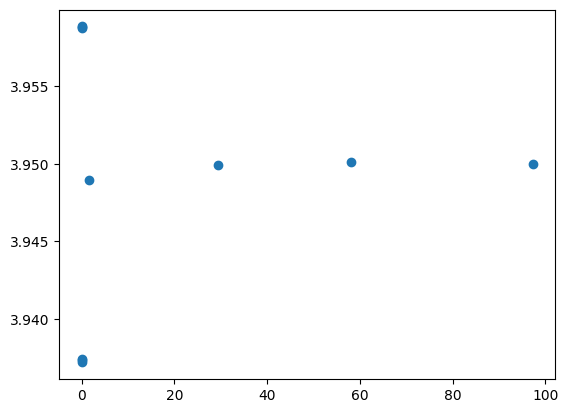

In [104]:
plt.plot(
    study.trials_dataframe()["params_h"],
    study.trials_dataframe()["value"],
    'o'
)

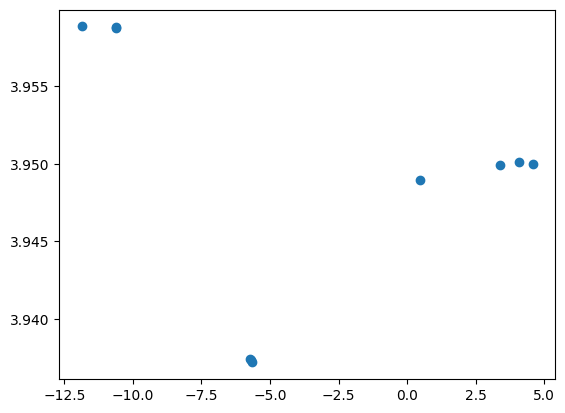

In [103]:
plt.plot(
    np.log(study.trials_dataframe()["params_h"]),
    study.trials_dataframe()["value"],
    'o'
)